In [1]:
# 這個Jupyter Notebook的環境
import platform
import tensorflow
import keras
print("Platform: {}".format(platform.platform()))
print("Tensorflow version: {}".format(tensorflow.__version__))
print("Keras version: {}".format(keras.__version__))

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
from IPython.display import Image

/home/dzw/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Platform: Linux-4.13.0-38-generic-x86_64-with-debian-stretch-sid
Tensorflow version: 1.7.0
Keras version: 2.1.5


In [2]:
# 数据集使用之前的dog_vs_cat
from keras.applications import VGG16
conv_base = VGG16(weights='imagenet',include_top=False,input_shape=(150,150,3))

In [3]:
conv_base.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

In [5]:
#方法1： 特征提取+新的分类层
import os
import numpy as np
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(rescale=1./255)
batch_size=20

In [6]:
#提取特征步骤
def extract_features(directory, sample_cnt): 
    '''
    sample_cnt:要处理的数目
    '''
    features = np.zeros(shape=(sample_cnt, 4,4,512))#vgg最后一层的输出尺寸
    labels = np.zeros(shape=(sample_cnt))
    
    generator = datagen.flow_from_directory(
        directory,
        target_size=(150,150),
        batch_size=batch_size,
        class_mode='binary'
    )
    
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch) #原始层提取特征
        features[i*batch_size:(i+1)*batch_size] = features_batch
        labels[i*batch_size:(i+1)*batch_size] = labels_batch
        i+=1
        if i*batch_size>=sample_cnt:
            break
    print('extract_features complete')
    return features, labels

In [9]:
train_dir = 'data/train'
valid_dir = 'data/valid'
test_dir = 'data/test'

In [8]:
train_features, train_labels = extract_features(train_dir, 2000)
valid_features, valid_labels = extract_features(valid_dir, 2000)
tests_features, test_labels = extract_features(test_dir, 2000)

Found 4322 images belonging to 2 classes.
extract_features complete
Found 3500 images belonging to 2 classes.
extract_features complete
Found 3890 images belonging to 2 classes.
extract_features complete


In [17]:
train_features = np.reshape(train_features, (2000, 4 * 4 * 512))
valid_features = np.reshape(valid_features, (2000, 4 * 4 * 512))
tests_features = np.reshape(tests_features, (2000, 4 * 4 * 512))

In [18]:
# 连接分类层步骤
from keras import models
from keras.layers import *
from keras import optimizers

model = models.Sequential()
model.add(Dense(256,activation='relu',input_dim=4*4*512))
model.add(Dropout(0.5))
model.add(Dense(1,activation='sigmoid'))

model.compile(optimizer=optimizers.Adam(lr=1e-4),
              loss='binary_crossentropy',
              metrics=['acc']
             )
history = model.fit(train_features,train_labels,
                    epochs=10,
                    batch_size=20,
                    validation_data=(valid_features,valid_labels)
                   )

Train on 2000 samples, validate on 2000 samples
Epoch 1/10
2000/2000 [==============================] - 1s 746us/step - loss: 0.4278 - acc: 0.7935 - val_loss: 0.3098 - val_acc: 0.8690
Epoch 2/10
2000/2000 [==============================] - 0s 216us/step - loss: 0.2781 - acc: 0.8800 - val_loss: 0.2790 - val_acc: 0.8830
Epoch 3/10
2000/2000 [==============================] - 0s 215us/step - loss: 0.2237 - acc: 0.9075 - val_loss: 0.2646 - val_acc: 0.8875
Epoch 4/10
2000/2000 [==============================] - 0s 217us/step - loss: 0.1930 - acc: 0.9275 - val_loss: 0.2851 - val_acc: 0.8705
Epoch 5/10
2000/2000 [==============================] - 0s 216us/step - loss: 0.1678 - acc: 0.9350 - val_loss: 0.2487 - val_acc: 0.8935
Epoch 6/10
2000/2000 [==============================] - 0s 218us/step - loss: 0.1307 - acc: 0.9565 - val_loss: 0.2522 - val_acc: 0.8880
Epoch 7/10
2000/2000 [==============================] - 1s 290us/step - loss: 0.1184 - acc: 0.9665 - val_loss: 0.2485 - val_acc: 0.8925


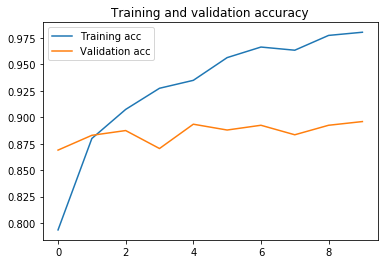

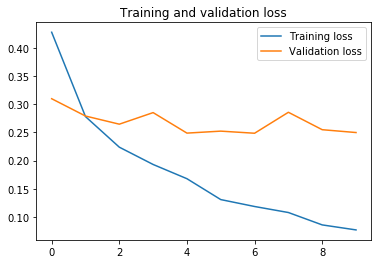

In [19]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, label='Training acc')
plt.plot(epochs, val_acc, label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

#不需要用到数据增强，速度很快，但是会过你拟合

# 冻结+串接新的模型


In [4]:
# 冻结+串接新的模型


from keras import models
from keras import layers
model = models.Sequential() # 產生一個新的網絡模型結構
model.add(conv_base)        # 把預訓練的卷積基底疊上去
model.add(layers.Flatten()) # 打平
model.add(layers.Dense(256, activation='relu'))  # 疊上新的密集連接層來做為分類器
model.add(layers.Dense(1, activation='sigmoid')) # 因為我的資料集只有兩類(cat & dog)

In [5]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 16,812,353
Non-trainable params: 0
_________________________________________________________________


In [6]:
# 看一下“凍結前”有多少可以被訓練的權重
print('This is the number of trainable weights '
      'before freezing the conv base:', len(model.trainable_weights))

This is the number of trainable weights before freezing the conv base: 30


In [7]:
# “凍結”卷積基底
conv_base.trainable = False

In [8]:
# 再看一下“凍結後”有多少可以被訓練的權重
print('This is the number of trainable weights '
      'after freezing the conv base:', len(model.trainable_weights))
# 4 是两个dense层的weight 和 bias

This is the number of trainable weights after freezing the conv base: 4


In [11]:
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers

train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

# 請注意: 驗證用的資料不要進行資料的增強
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # 圖像資料的目錄
        train_dir,
        # 設定圖像的高(height)與寬(width)
        target_size=(150, 150),
        batch_size=20,
        # 因為我們的目標資料集只有兩類(cat & dog)
        class_mode='binary')

valid_generator = test_datagen.flow_from_directory(
        valid_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=2e-5),
              metrics=['acc'])

history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=30,
      validation_data=valid_generator,
      validation_steps=50,
      verbose=2)

Found 4322 images belonging to 2 classes.
Found 3500 images belonging to 2 classes.
Epoch 1/30
 - 16s - loss: 0.5993 - acc: 0.6810 - val_loss: 0.4656 - val_acc: 0.8030
Epoch 2/30
 - 13s - loss: 0.5105 - acc: 0.7550 - val_loss: 0.3803 - val_acc: 0.8460
Epoch 3/30
 - 11s - loss: 0.4468 - acc: 0.8015 - val_loss: 0.3438 - val_acc: 0.8560
Epoch 4/30
 - 12s - loss: 0.4253 - acc: 0.8125 - val_loss: 0.3293 - val_acc: 0.8520
Epoch 5/30
 - 12s - loss: 0.4124 - acc: 0.8090 - val_loss: 0.3191 - val_acc: 0.8630
Epoch 6/30
 - 12s - loss: 0.3701 - acc: 0.8305 - val_loss: 0.3003 - val_acc: 0.8740
Epoch 7/30
 - 12s - loss: 0.3777 - acc: 0.8350 - val_loss: 0.3103 - val_acc: 0.8600
Epoch 8/30
 - 11s - loss: 0.3804 - acc: 0.8270 - val_loss: 0.2813 - val_acc: 0.8790
Epoch 9/30
 - 11s - loss: 0.3779 - acc: 0.8305 - val_loss: 0.2818 - val_acc: 0.8740
Epoch 10/30
 - 11s - loss: 0.3714 - acc: 0.8360 - val_loss: 0.2740 - val_acc: 0.8770
Epoch 11/30
 - 11s - loss: 0.3398 - acc: 0.8405 - val_loss: 0.2800 - val_ac

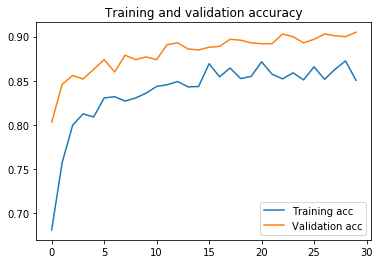

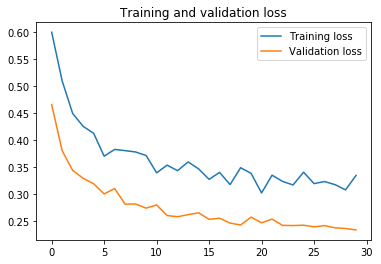

In [12]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, label='Training acc')
plt.plot(epochs, val_acc, label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()


#准确率更好，但是速度更慢

# fine tune 微调
冻结顶层， 添加新的模型部分进行训练

In [13]:
conv_base.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

In [14]:
conv_base.trainable = True

layers_frozen = ['block5_conv1','block5_conv2', 'block5_conv3', 'block5_pool']

for layer in conv_base.layers:
    if layer.name in layers_frozen:
        layer.trainable = True
    else:
        layer.trainable = False
        
for layer in conv_base.layers:
    print("{}: {}".format(layer.name, layer.trainable))        


input_1: False
block1_conv1: False
block1_conv2: False
block1_pool: False
block2_conv1: False
block2_conv2: False
block2_pool: False
block3_conv1: False
block3_conv2: False
block3_conv3: False
block3_pool: False
block4_conv1: False
block4_conv2: False
block4_conv3: False
block4_pool: False
block5_conv1: True
block5_conv2: True
block5_conv3: True
block5_pool: True


In [16]:
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-5), # 使用小的learn rate
              metrics=['acc'])

history = model.fit_generator(
      train_generator,
      steps_per_epoch=,
      epochs=100,
      validation_data=valid_generator,
      validation_steps=50)

Epoch 1/100
100/100 [==============================] - 14s 143ms/step - loss: 0.3239 - acc: 0.8550 - val_loss: 0.2183 - val_acc: 0.9070
Epoch 2/100
100/100 [==============================] - 12s 124ms/step - loss: 0.2874 - acc: 0.8790 - val_loss: 0.2316 - val_acc: 0.9050
Epoch 3/100
100/100 [==============================] - 12s 118ms/step - loss: 0.2718 - acc: 0.8820 - val_loss: 0.1907 - val_acc: 0.9220
Epoch 4/100
100/100 [==============================] - 12s 118ms/step - loss: 0.2445 - acc: 0.8930 - val_loss: 0.1811 - val_acc: 0.9240
Epoch 5/100
100/100 [==============================] - 12s 116ms/step - loss: 0.2354 - acc: 0.9080 - val_loss: 0.1881 - val_acc: 0.9300
Epoch 6/100
100/100 [==============================] - 12s 118ms/step - loss: 0.2463 - acc: 0.8970 - val_loss: 0.2232 - val_acc: 0.9060
Epoch 7/100
100/100 [==============================] - 12s 117ms/step - loss: 0.2277 - acc: 0.8965 - val_loss: 0.1743 - val_acc: 0.9300
Epoch 8/100
100/100 [===========================

In [17]:
model.save('cats_and_dogs_small_4.h5')

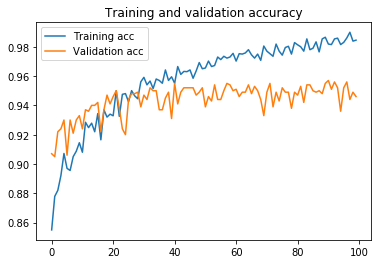

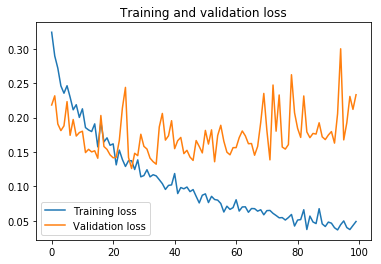

In [18]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, label='Training acc')
plt.plot(epochs, val_acc, label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

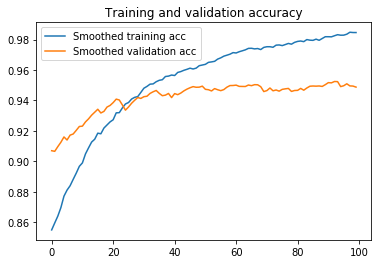

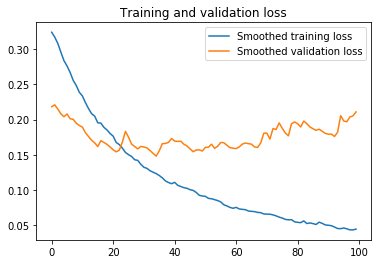

In [19]:
def smooth_curve(points, factor=0.8):  #向量法使图像平滑表示
  smoothed_points = []
  for point in points:
    if smoothed_points:
      previous = smoothed_points[-1]
      smoothed_points.append(previous * factor + point * (1 - factor))
    else:
      smoothed_points.append(point)
  return smoothed_points

plt.plot(epochs,
         smooth_curve(acc), label='Smoothed training acc')
plt.plot(epochs,
         smooth_curve(val_acc), label='Smoothed validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs,
         smooth_curve(loss), label='Smoothed training loss')
plt.plot(epochs,
         smooth_curve(val_loss), label='Smoothed validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [20]:
test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

test_loss, test_acc = model.evaluate_generator(test_generator, steps=50)
print('test acc:', test_acc)

Found 3890 images belonging to 2 classes.
test acc: 0.9359999930858612
